# Graph Representation with post-1 studies

### Data import

In [1]:
!pip install -q networkx

!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q git+https://github.com/rusty1s/pytorch_geometric.git

In [2]:
import os

import pandas as pd
import numpy as np

import networkx as nx
import torch
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.io as pio
pio.templates.default = 'seaborn'

In [3]:
DATA_DIR = '/datasets/data2021-09-20/'

lesions_file = 'melanoma_lesion-info_organ-overlap_2021-09-17_anonymized_cleaned_all.csv'
lesion_mapping_file = 'melanoma_lesion_mapping_2021-09-20_anonymized.csv'
patients_file = 'melanoma_patient-level_summary_anonymized.csv'
studies_file = 'melanoma_study_level_summary_anonymized.csv'

In [4]:
def extract_study_phase(n: str) -> int:
    status, number = n.split('-')
    sign = -1 if status == 'pre' else 1
    return sign * int(number)

def classify_response(row):
    # Compare current vs. baseline
    if row.tmtv < row.baseline:
        return 'response'
    elif row.tmtv == row.baseline:
        return 'baseline'
    else:
        return 'progression'

In [5]:
lesions = pd.read_csv(os.path.join(DATA_DIR, lesions_file))
lesions['study_phase'] = lesions.study_name.apply(extract_study_phase)

# Sorting by PARS classification allows for visualization consistency
lesions.sort_values(by='pars_classification_petct', inplace=True)
n_lesions, f_lesions = lesions.shape

print(f'Imported {n_lesions} lesions with {f_lesions} features. Null values: {lesions.isna().sum().sum()}')

Imported 20892 lesions with 18 features. Null values: 0


In [6]:
studies = pd.read_csv(os.path.join(DATA_DIR, studies_file))
studies.rename(columns={'is_malignant': 'malignant_lesions'}, inplace=True)
studies['study_phase'] = studies.study_name.apply(extract_study_phase)

n_studies, f_studies = studies.shape

print(f'Imported {n_studies} studies with {f_studies} features. Null values: {studies.isna().sum().sum()}')

Imported 472 studies with 23 features. Null values: 1043


In [7]:
# Compute TMTV by summing `vol_ccm` per study
labels = lesions.groupby(['gpcr_id', 'study_phase']).vol_ccm.sum().to_frame('tmtv').reset_index()

# Find `labels` id of each patient's baseline TMTV
baseline_idx = labels.groupby('gpcr_id').study_phase.idxmin().to_dict()
labels['baseline'] = labels.gpcr_id.apply(
    lambda i: labels.loc[baseline_idx[i]].tmtv)
labels['response'] = labels.apply(classify_response, axis=1)

print(f'Response computed for {labels.shape[0]} studies: \n{labels.response.value_counts()}')

Response computed for 460 studies: 
progression    198
response       137
baseline       125
Name: response, dtype: int64


### Create post-1 dataset

In [8]:
# Select only `post-1` phases
post1_labels = labels[labels.study_phase == 1][['gpcr_id', 'response']]

In [9]:
df = lesions[lesions.study_phase == 1].merge(post1_labels, on='gpcr_id')
df = df[df.response != 'baseline']
unwanted_features = ['study_name', 'roi_id', 'roi_name', 'lesion_label_id', 'study_phase']
df = df[[ feature for feature in list(df.columns) if feature not in unwanted_features ]]

df.head()

,gpcr_id,pars_bodypart_petct,pars_region_petct,pars_subregion_petct,pars_laterality_petct,pars_classification_petct,vol_ccm,max_suv_val,mean_suv_val,min_suv_val,sd_suv_val,is_malignant,assigned_organ,response
0,34610086,thorax,bones,scapula,left,benign,2.08,5.92,3.21,2.49,0.67,False,bones_thorax,progression
1,34610086,thorax,lymph nodes,IASLC station 4,left,benign,1.64,5.10,3.34,2.91,0.40,False,other_thorax,progression
2,34610086,thorax,heart,atrium,not specified,benign,9.66,5.51,3.01,2.59,0.38,False,other_thorax,progression
3,34610086,thorax,oesophagus,not specified,not specified,benign,9.72,6.02,3.51,2.83,0.58,False,other_thorax,progression
4,34610086,thorax,lymph nodes,IASLC station 4,right,benign,2.53,5.58,3.01,2.62,0.37,False,other_thorax,progression


In [10]:
print(f'Total patients with non-baseline post-1 studies: {len(df.gpcr_id.unique())}')

Total patients with non-baseline post-1 studies: 64


In [11]:
patients = list(df[df.response == 'progression'].gpcr_id.unique())

In [12]:
patient = '34610073'

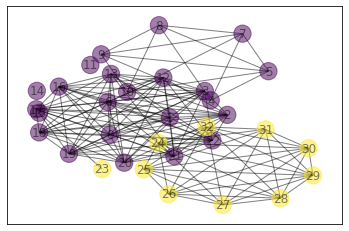

In [13]:
pdf = df[df.gpcr_id == int(patient)].reset_index()

num_nodes = pdf.shape[0]
edge_index = []

for i in range(num_nodes):
    source = pdf.loc[i].assigned_organ
    targets = list(pdf[pdf.assigned_organ == source].index)

    edge_index.extend([ [i, j] for j in targets if i != j  ])

x = torch.tensor(list(pdf.is_malignant.astype(int)))

G1 = Data(x=x, edge_index=torch.tensor(edge_index).t(), num_nodes=num_nodes)

G = to_networkx(G1, to_undirected=True)
pos = nx.kamada_kawai_layout(G)

nx.draw_networkx(G, pos, node_color=G1.x, alpha=0.5)

### Lesion classifier baselines

In [14]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [15]:
x_features = list(df.columns)
x_features.remove('response')
x_features.remove('gpcr_id')
x_features.remove('is_malignant')

x_features_categorical = ['pars_bodypart_petct', 'pars_region_petct', 
                          'pars_subregion_petct', 'pars_laterality_petct',
                          'pars_classification_petct', 'assigned_organ']
x_features_numerical = ['vol_ccm', 'max_suv_val', 'mean_suv_val',
                        'min_suv_val', 'sd_suv_val']

In [16]:
y = (df.response == 'response').astype(int)

encoder = OneHotEncoder(drop='if_binary')
scaler = StandardScaler()
X = np.concatenate((   
        encoder.fit_transform(df[x_features_categorical]).todense(),
        scaler.fit_transform(df[x_features_numerical])
    ),
    axis=1)

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.33, random_state=27)

In [17]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "Logistic Regression"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    LogisticRegression(penalty='l2', solver='liblinear')]

In [18]:
scores = []

for name, clf in zip(names, classifiers):

    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))

In [19]:
list(zip(names, scores))

[('Nearest Neighbors', 0.6790697674418604),
 ('Linear SVM', 0.6666666666666666),
 ('RBF SVM', 0.6751937984496124),
 ('Gaussian Process', 0.7077519379844961),
 ('Decision Tree', 0.7054263565891473),
 ('Random Forest', 0.6674418604651163),
 ('Neural Net', 0.6829457364341085),
 ('AdaBoost', 0.689922480620155),
 ('Naive Bayes', 0.3612403100775194),
 ('Logistic Regression', 0.6643410852713179)]

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7360151b-146e-499a-b01b-835ca18c34fa' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>